## Задание

Предоставлен набор данных, содержащий следующие переменные:

**Переменные, характеризующие кредитную историю клиента**  
closed_cred_sum - сумма, которую клиент выплатил по ранее взятым и закрытым
кредитам  
closed_creds - количество закрытых кредитов  
active_cred_sum_overdue - суммарная задолженность по активным кредитам
active_cred_sum - сумма всех активных кредитов  
active_cred_day_overdue - суммарная просрочка в днях по всем активным кредитам  
active_cred_max_overdue - максимальная сумма просроченной задолженности по
активным кредитам  

**Переменные характеризующие клиента**  
age - возраст  
gender - пол  
region - регион  
month_income - ежемесячный доход  

**Переменные, характеризующие кредит, по которому нужно сделать
прогноз**  
first_loan - сумма, которую клиент хочет получить в кредит (из заявки)  
first_days_quant - срок, на которую клиент хочет взять кредит  
loan_cost_all - одобренная клиенту сумма кредита  
order_date - дата подачи заявки на получение кредита  
cost_all - сумма всех выплат по одобренному кредиту  
order_id - id заявки  
client_id - id клиента  

**Целевая переменная:**  
expert - решение, которое принято по заявке (0 - одобрено, 1 - отклонено).  
Задача - на основе предоставленных данных построить модель для предсказания
целевой переменной

## Содержание
[1. Предобработка данных](#1.-Предобработка-данных)  
[2. Исследовательский анализ данных](#2.-Исследовательский-анализ-данных)  
[3. Моделирование](#3.-Моделирование)  
[4. Оценка модели](#4.-Оценка-модели)  
[5. Интерпретация модели](#5.-Интерпретация-модели)  
[6. Вывод](#6.-Вывод) 

# 1. Предобработка данных

- Загрузим данные
- Посмотрим типы данных
- Общее описание числовых переменных 
- Посмотрим аномалии, пропуски, дубликаты

In [1]:
#pip install lightgbm

In [2]:
#pip install eli5

In [3]:
#pip install shap

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
import datetime as dt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, plot_roc_curve, classification_report
from lightgbm import LGBMClassifier
import eli5
from eli5.sklearn import PermutationImportance
from eli5.lightgbm import explain_weights_lightgbm
from sklearn.calibration import calibration_curve
import shap #библиотека для расчета SHAP-values
import warnings
warnings.filterwarnings("ignore")

Предварительно загрузим данные курса доллара к рублю. Будем использовать как экономический фактор 

In [5]:
rc = pd.read_excel('RC_F26_06_2017_T25_09_2017.xlsx', parse_dates=[1])
rc.head()

,nominal,data,curs,cdx
0,1,2017-09-23,57.6527,Доллар США
1,1,2017-09-22,58.2242,Доллар США
2,1,2017-09-21,58.1290,Доллар США
3,1,2017-09-20,58.0993,Доллар США
4,1,2017-09-19,57.6242,Доллар США


Оставим только дату и курс

In [6]:
rc = rc[['data', 'curs']].sort_values('data').set_index('data')
rc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2017-06-27 to 2017-09-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   curs    65 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


In [7]:
# заружаем данные
df = pd.read_csv('./data.csv', sep=';', parse_dates=['order_date'])
df.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
0,143822.0,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,2017-07-23,0.0,728319,320464,1
1,0.0,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,2017-07-23,0.0,728321,320466,1
2,51356.0,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,2017-07-23,0.0,728323,320467,1
3,0.0,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,2017-07-23,0.0,728447,320533,1
4,12298.0,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,2017-07-23,0.0,728421,298598,1


In [8]:
print(f'В таблице {df.shape[0]} строка и {df.shape[1]} колонок')

В таблице 50001 строка и 18 колонок


In [9]:
# посмотрим типы данных
df.dtypes

closed_cred_sum                   float64
closed_creds                        int64
active_cred_sum_overdue           float64
active_cred_sum                   float64
active_cred_day_overdue             int64
active_cred_max_overdue           float64
age                                 int64
gender                              int64
region                              int64
first_loan                        float64
loan_cost_all                       int64
first_days_quant                    int64
month_income                      float64
order_date                 datetime64[ns]
cost_all                          float64
order_id                            int64
client_id                           int64
expert                              int64
dtype: object

- переменную `order_date` привели к типу datetime при загрузке данных
- категориальные переменные `gender` и `region` уже закодированы
- остальные: числовые переменные в порядке

In [10]:
# проверяем пропуски
df.isna().sum()

closed_cred_sum             0
closed_creds                0
active_cred_sum_overdue     0
active_cred_sum             0
active_cred_day_overdue     0
active_cred_max_overdue     0
age                         0
gender                      0
region                      0
first_loan                 19
loan_cost_all               0
first_days_quant            0
month_income                0
order_date                  0
cost_all                    0
order_id                    0
client_id                   0
expert                      0
dtype: int64

Присутствуют пропуски в переменной `first_loan`. Здравый смысл подсказывает, что запрашиваемая кредитная сумма это важный признак

In [11]:
# посмотрим объекты с пропусками
df[df['first_loan'].isna()]

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
184,2722669.00,59,0.00,891500.00,0,8956.61,57,0,40,NaN,10000,10,87000.0,2017-07-25,0.0,730831,183863,1
7150,765963.00,8,589946.45,1025000.00,4418,259317.43,53,0,40,NaN,2000,20,40000.0,2017-07-01,0.0,702433,306898,1
8848,23500.00,4,12594.87,287250.00,282,8500.00,22,0,40,NaN,2000,20,42000.0,2017-07-03,0.0,705194,214622,1
13176,24000.00,3,2230.20,3000.00,5,2230.20,22,0,0,NaN,2000,20,25000.0,2017-07-08,0.0,711678,197369,1
13461,934734.29,97,0.00,307449.02,0,764.82,25,1,0,NaN,2500,20,50000.0,2017-07-08,3590.0,712046,231691,0
13581,0.00,0,15000.00,15000.00,137,15000.00,18,0,78,NaN,2000,20,30000.0,2017-07-08,0.0,712179,227008,1
24461,1653801.90,117,255644.29,672187.99,2744,60076.09,36,1,4,NaN,2000,20,40000.0,2017-07-24,0.0,729540,236614,1
30659,5337.00,1,37124.07,38567.00,1435,37124.07,25,0,65,NaN,2000,20,25000.0,2017-07-30,0.0,738690,149577,1
31243,62709.00,7,50641.35,67496.00,3579,45027.00,36,0,78,NaN,2000,20,26000.0,2017-07-31,0.0,740962,309289,1
32363,129000.00,4,73506.93,83500.00,4801,47506.93,31,0,78,NaN,1000,23,45000.0,2017-07-31,1501.4,741054,324256,0


- у большинства клиентов есть закрытые кредиты
- сумма запроса должна быть не меньше суммы одобренной, исходя из этого можем заполнить пропуски значениями из `loan_cost_all`

In [12]:
# заполним пропуски
nan_idx = df[df['first_loan'].isna()]['first_loan'].index 
df.loc[nan_idx, 'first_loan'] = df.loc[nan_idx, 'loan_cost_all']

# проверяем
print('Пропусков в first_loan:', df['first_loan'].isna().sum())

Пропусков в first_loan: 0


Проверим данные на полные дубликаты строк

In [13]:
# провряем дубликаты
print('Количество дубликатов:', df.duplicated().sum())
print('Доля дубликатов:{:.2%}'.format(df.duplicated().sum() / len(df)))

Количество дубликатов: 7058
Доля дубликатов:14.12%


- 14% дубликатов может испортить результаты моделирования 
- дубликаты удалим

In [14]:
# удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)

# проверяем 
print('Количество дубликатов', df.duplicated().sum())

Количество дубликатов 0


In [15]:
df.describe()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,order_id,client_id,expert
count,4.294300e+04,42943.000000,4.294300e+04,4.294300e+04,42943.000000,4.294300e+04,42943.000000,42943.000000,42943.000000,42943.000000,42943.000000,42943.000000,42943.000000,42943.000000,42943.000000,42943.000000,42943.000000
mean,1.799664e+05,7.836644,4.978639e+04,1.887133e+05,703.097664,3.645347e+04,35.010945,0.459167,28.452227,7723.146962,6631.059777,24.159840,25514.705086,1307.000051,731756.527280,285367.018606,0.738514
std,5.101102e+05,13.976756,2.472462e+05,4.245794e+05,1339.547943,1.694200e+05,11.332712,0.498336,29.717546,5460.340181,4696.021880,37.743369,20536.655458,4688.412827,25059.575574,76416.806001,0.439449
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,695828.000000,109.000000,0.000000
25%,5.000000e+03,1.000000,0.000000e+00,1.350000e+04,0.000000,3.505600e+02,27.000000,0.000000,0.000000,5000.000000,3000.000000,10.000000,0.000000,0.000000,712933.000000,285886.000000,0.000000
50%,3.983500e+04,3.000000,5.000000e+03,5.443082e+04,61.000000,6.431000e+03,32.000000,0.000000,24.000000,7000.000000,7000.000000,20.000000,26000.000000,0.000000,730650.000000,313320.000000,1.000000
75%,1.650000e+05,9.000000,3.041960e+04,1.887584e+05,903.000000,2.345835e+04,41.000000,1.000000,52.000000,10000.000000,10000.000000,20.000000,35000.000000,0.000000,746591.000000,326691.500000,1.000000
max,4.457421e+07,563.000000,3.303100e+07,2.273166e+07,21927.000000,2.170166e+07,99.000000,1.000000,99.000000,100000.000000,100000.000000,336.000000,550000.000000,238770.420000,840692.000000,393528.000000,1.000000


- отрицательные значения отсутствуют

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42943 entries, 0 to 42942
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   closed_cred_sum          42943 non-null  float64       
 1   closed_creds             42943 non-null  int64         
 2   active_cred_sum_overdue  42943 non-null  float64       
 3   active_cred_sum          42943 non-null  float64       
 4   active_cred_day_overdue  42943 non-null  int64         
 5   active_cred_max_overdue  42943 non-null  float64       
 6   age                      42943 non-null  int64         
 7   gender                   42943 non-null  int64         
 8   region                   42943 non-null  int64         
 9   first_loan               42943 non-null  float64       
 10  loan_cost_all            42943 non-null  int64         
 11  first_days_quant         42943 non-null  int64         
 12  month_income             42943 n

- выполнили предобработку данных
- заполнили пропуски 
- удалили дубликаты, тем самым количестов данных уменьшилось на 14%

# 2. Исследовательский анализ данных

На данном этапе:
1. Посмотрим распределения данных.
2. Поищем выбросы в переменных. 
3. Иследуем взаимосвязи между переменными. 

In [17]:
# сохраним список числовых переменных
num_cols = df.drop(['gender', 'region', 'order_date', 'expert'], axis=1).columns.tolist()
num_cols

['closed_cred_sum',
 'closed_creds',
 'active_cred_sum_overdue',
 'active_cred_sum',
 'active_cred_day_overdue',
 'active_cred_max_overdue',
 'age',
 'first_loan',
 'loan_cost_all',
 'first_days_quant',
 'month_income',
 'cost_all',
 'order_id',
 'client_id']

In [18]:
def histplot(df, cols):
    """
    функция для построение гистограмм
    df - датафрей
    cols - список признаков
    """
    for col in cols:
        plt.figure(figsize=(12,6))
        sns.histplot(df[col], bins=500)
        plt.xlim(0, df[col].quantile(0.99))
        plt.title(f'Гистограмма распределения {col}')
        plt.show()
        
def boxplot(df, cols):
    """
    функция для построение диаграмм бокспот
    df - датафрей
    cols - список признаков
    """
    for col in cols:
        plt.figure(figsize=(16,6))
        sns.boxplot(data=df, x=col)
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        plt.axvline(q1-3*iqr, linestyle='-', label='q1-3*iqr')
        plt.axvline(q3+3*iqr, linestyle='--', label='q3+3*iqr')
        plt.xlim(0)
        plt.title(f'Диаграмма боксплот {col}')
        plt.legend()
        plt.show()

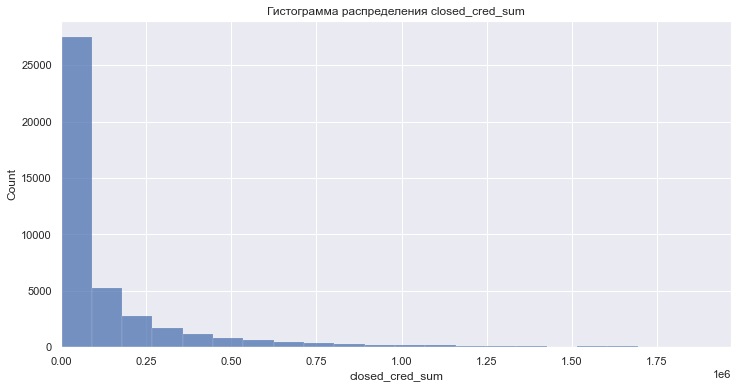

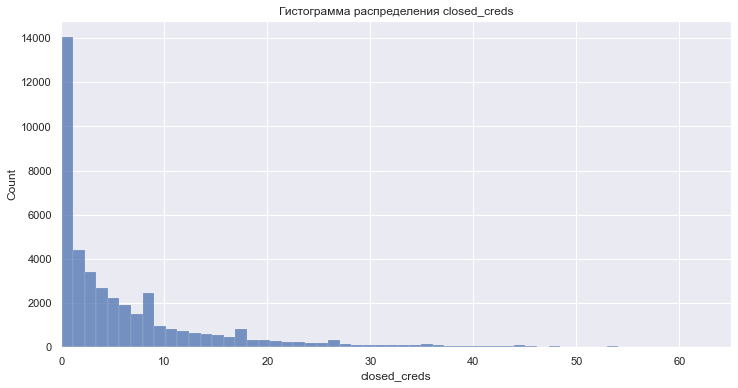

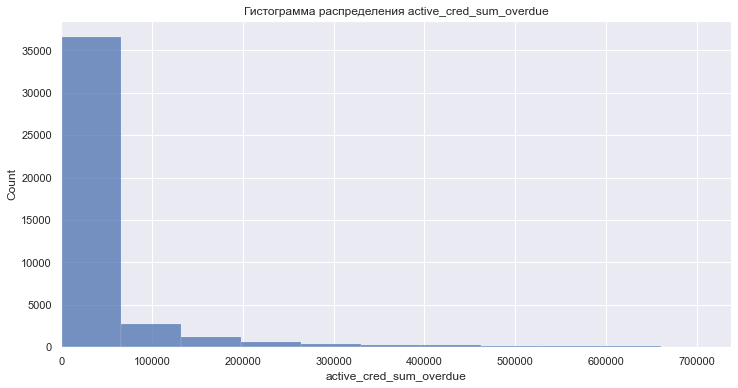

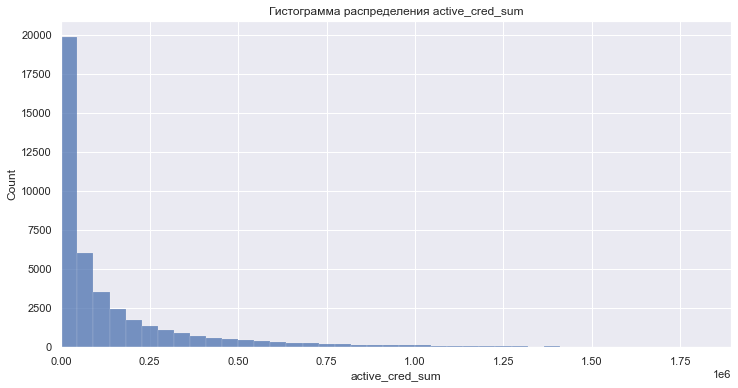

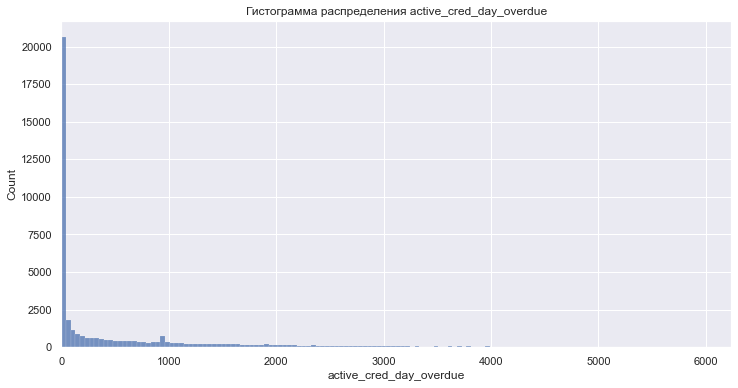

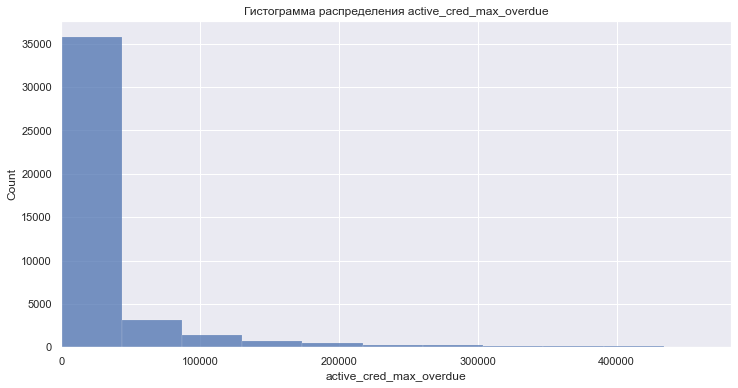

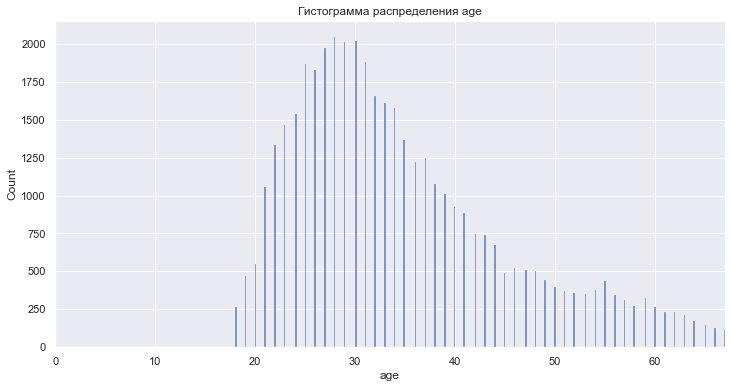

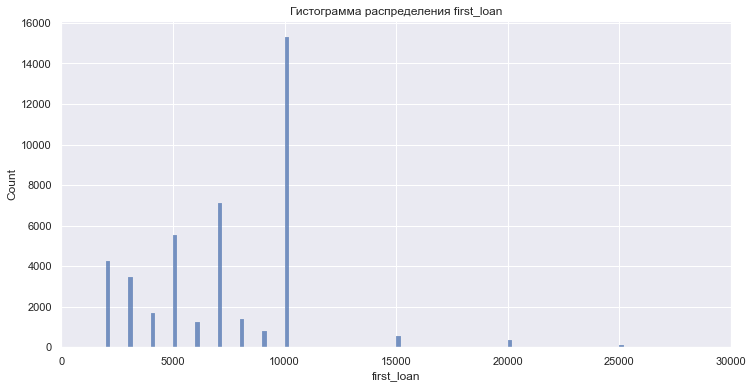

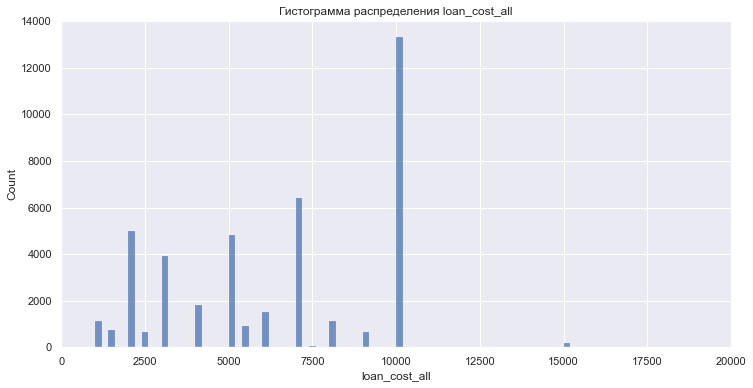

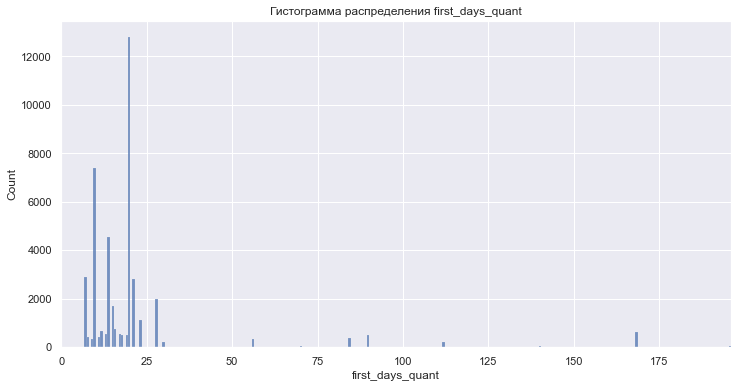

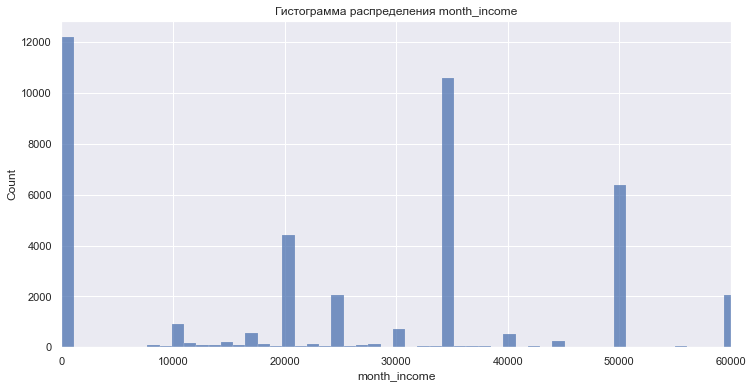

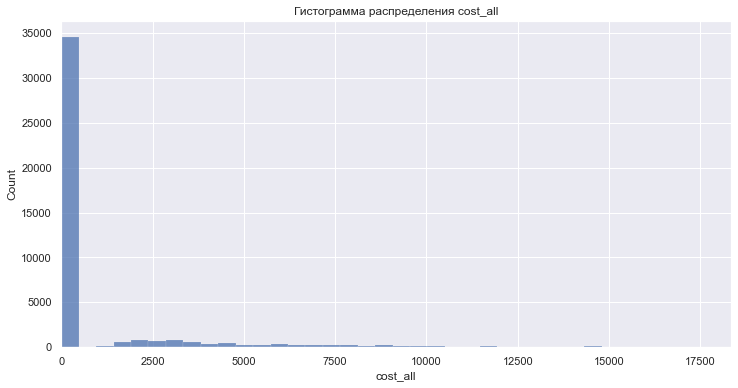

In [19]:
# строим гистограммы
histplot(df, num_cols[:-2])

- распределение сумм близко пуассоновскому
- распределение возраста близко к нормальному распределению 
- значимая доля клиентов с нулевым ежемесячным доходом

In [20]:
print('Клиентов с нулевым доходом: {:.1%}'.format(df[df['month_income'] == 0].shape[0] / df.shape[0]))

Клиентов с нулевым доходом: 28.4%


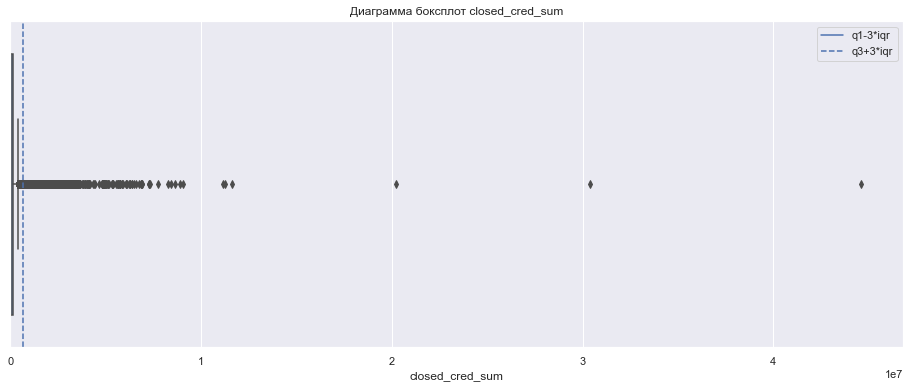

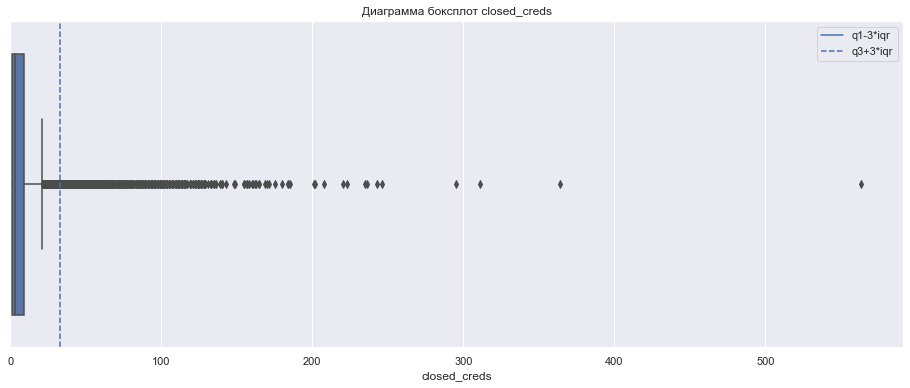

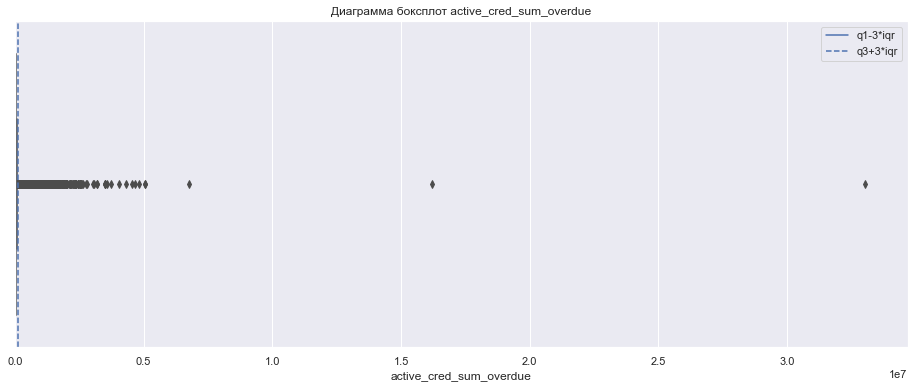

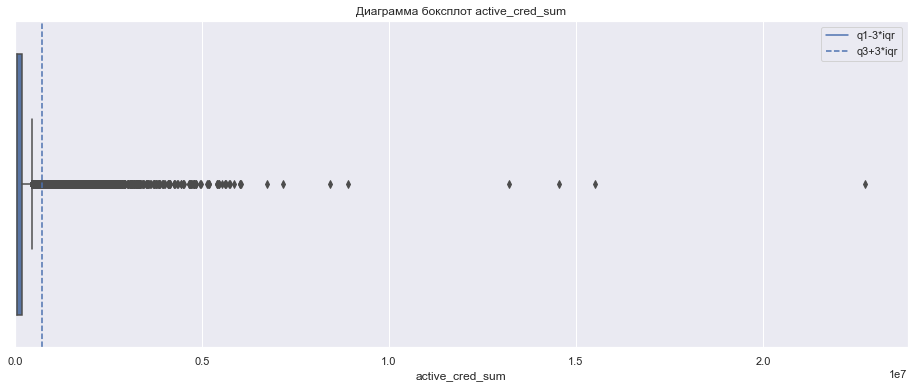

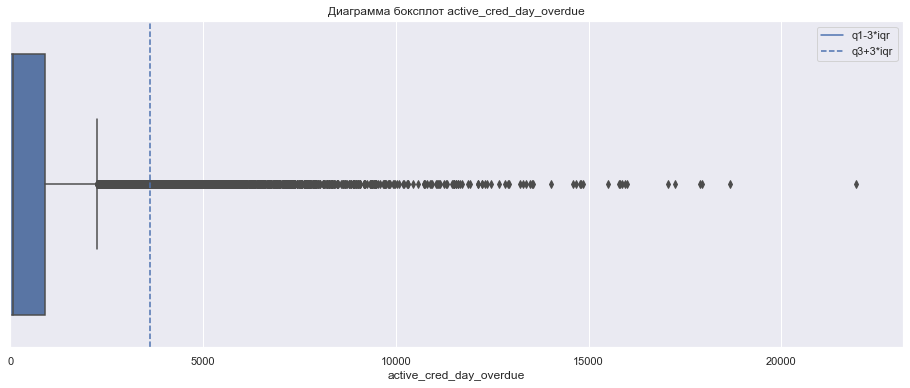

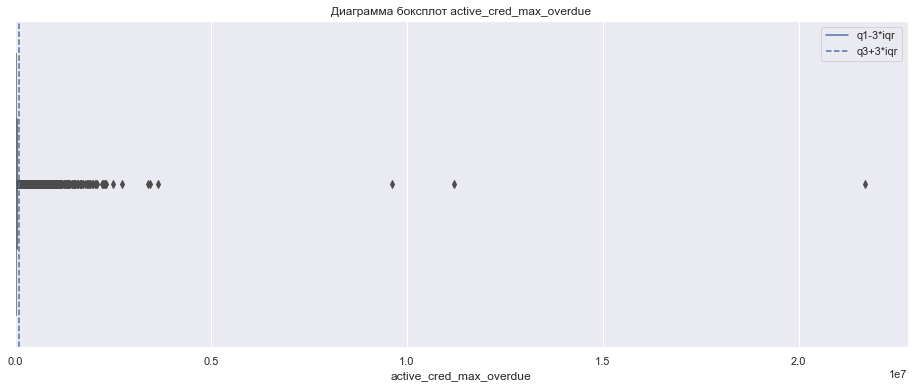

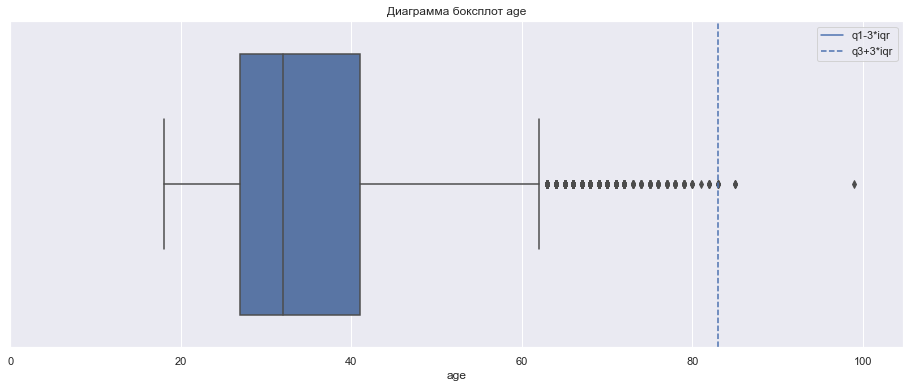

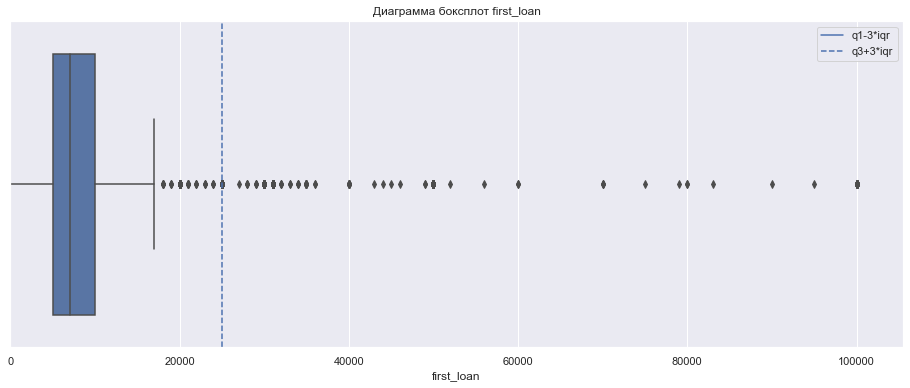

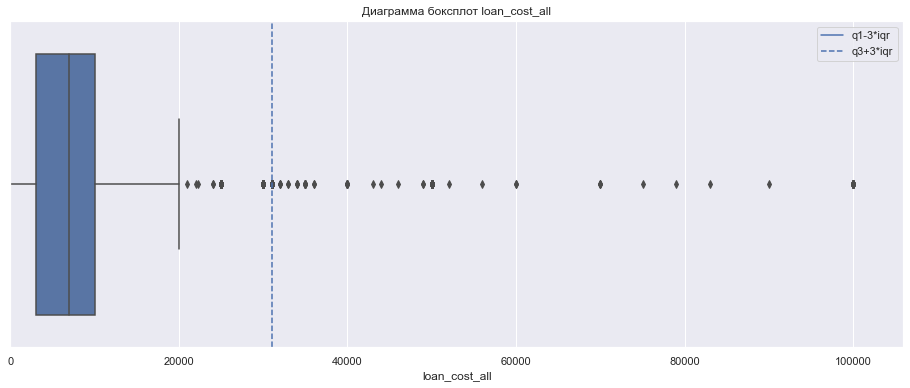

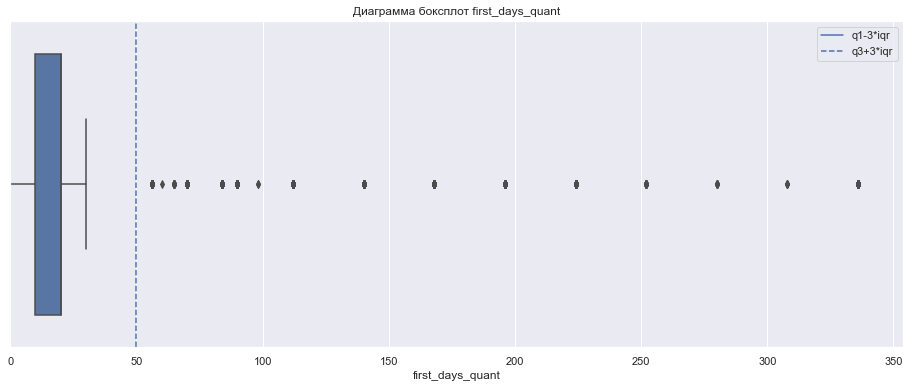

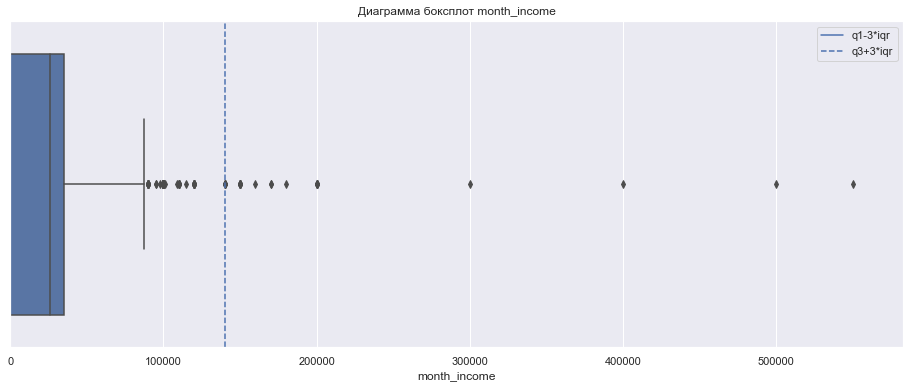

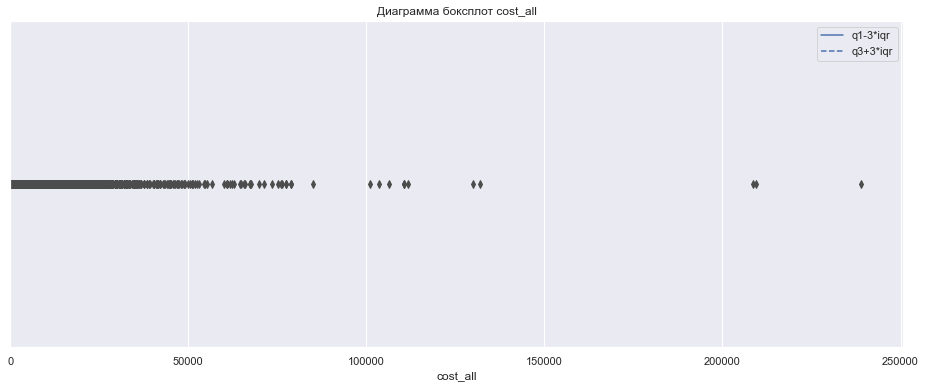

In [21]:
# стром диагрммы
boxplot(df, num_cols[:-2])

- выбросы могут иметь естественную природу
- чистить от выбросов не будем
- объекты с большим доходом, больше трех интерквартильных размахов, выглядят подозрительно
- есть объект возрастом старше 90 лет

Исходя из здравого смысла, выбросы могут иметь естественную природу. Поэтому оставим переменные без фильтрации

Посмотрим распределение категориальных переменных

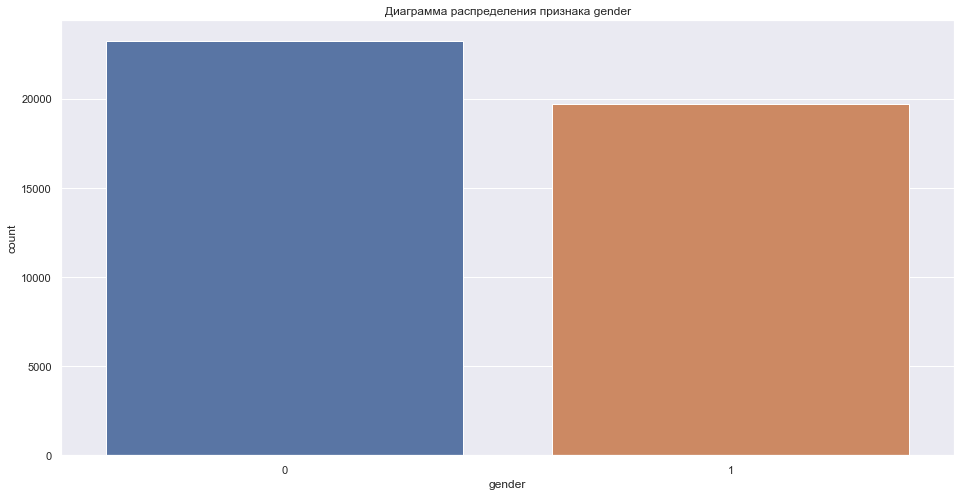

In [22]:
# строим диаграмму
sns.countplot(data=df, x='gender')
plt.title('Диаграмма распределения признака gender')
plt.show()

- по гендерному признаку данные сбалансированы

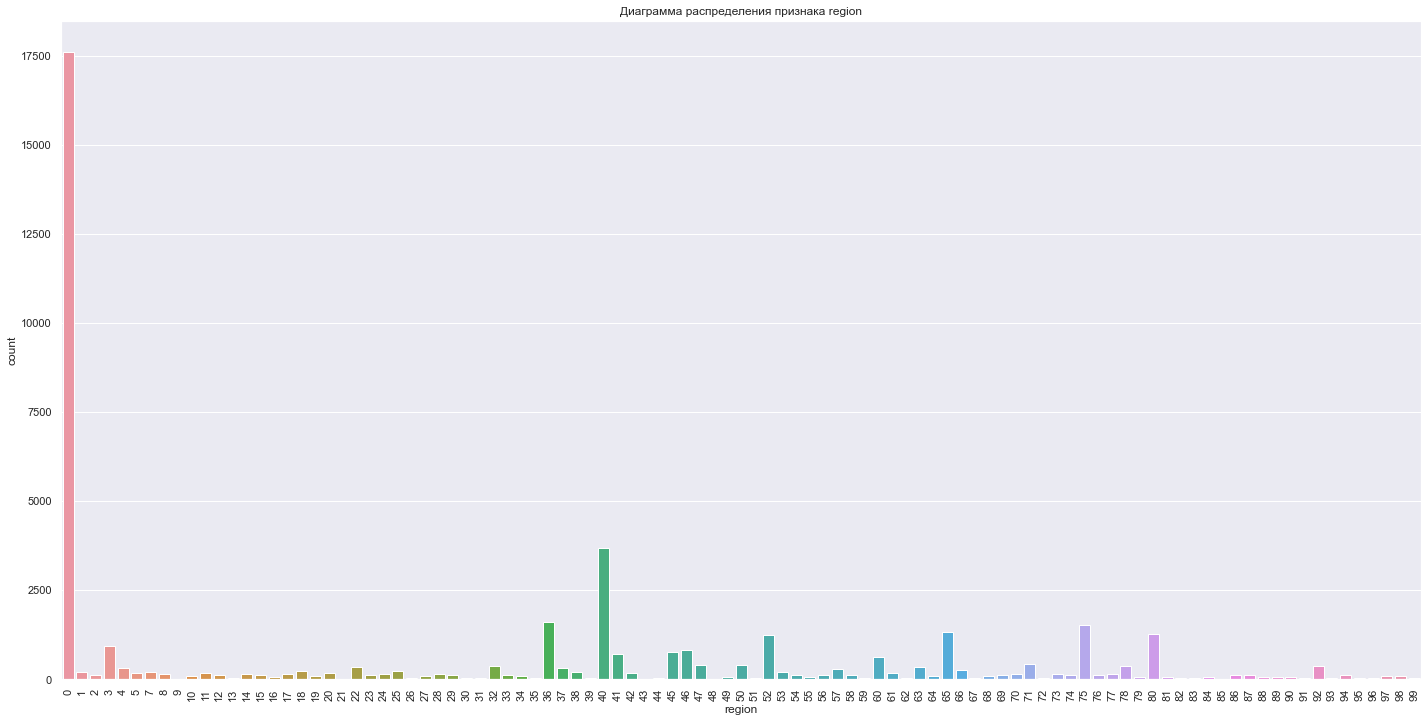

In [23]:
plt.figure(figsize=(20,10))
sns.countplot(data=df, x='region')
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Диаграмма распределения признака region')
plt.show()

- в основном данные о регионах заполнены нулевым значением
- преобладает регион 40

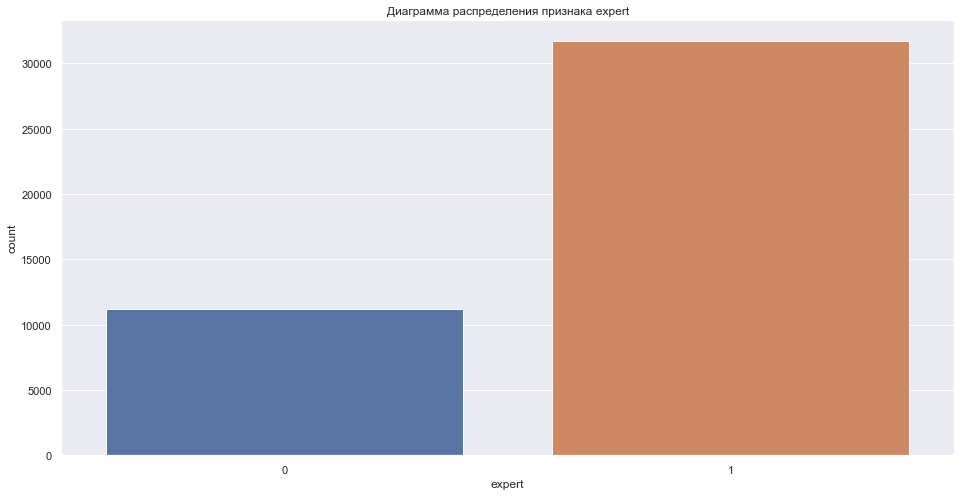

In [24]:
# строим диаграмму целевой переменной
sns.countplot(data=df, x='expert')
plt.title('Диаграмма распределения признака expert')
plt.show()

- процент отказов около 75 %
- данные не сбалансированы по целевому признаку
- стоит учитывать данный факт при обучении модели

Посмотрим как изменяется количество отказов во времени

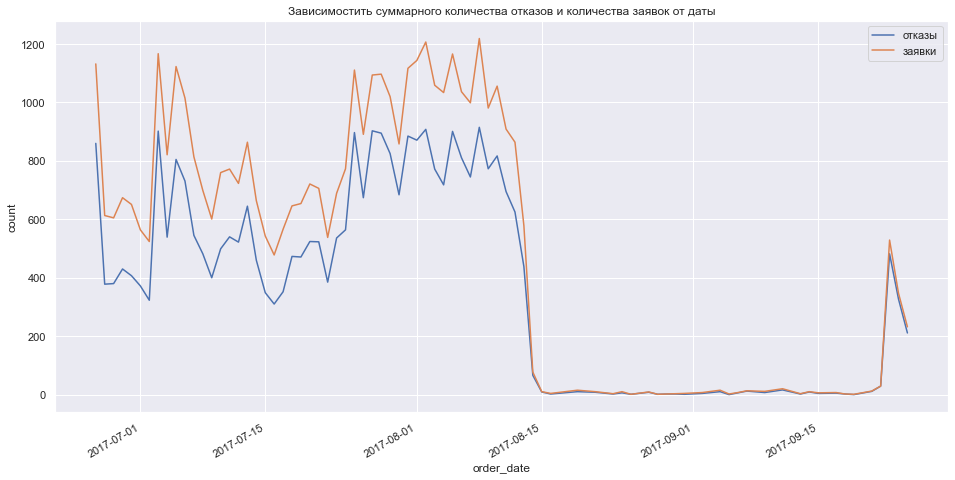

In [25]:
# строим график зависимости от времени
df.groupby('order_date')['expert'].sum().plot()
df.groupby('order_date')['expert'].count().plot()
plt.ylabel('count')
plt.legend(['отказы', 'заявки'])
plt.title('Зависимостить суммарного количества отказов и количества заявок от даты')
plt.show()

- с середины июля заметен возрастающий тренд по заявкам 
- в период с середины августа до конца сентября уменьшилось количество заявок, либо данные за период отсутствуют

Проверим гипотезу о пропущенных данных. Посмотрим растет ли линейно id заявки от времени

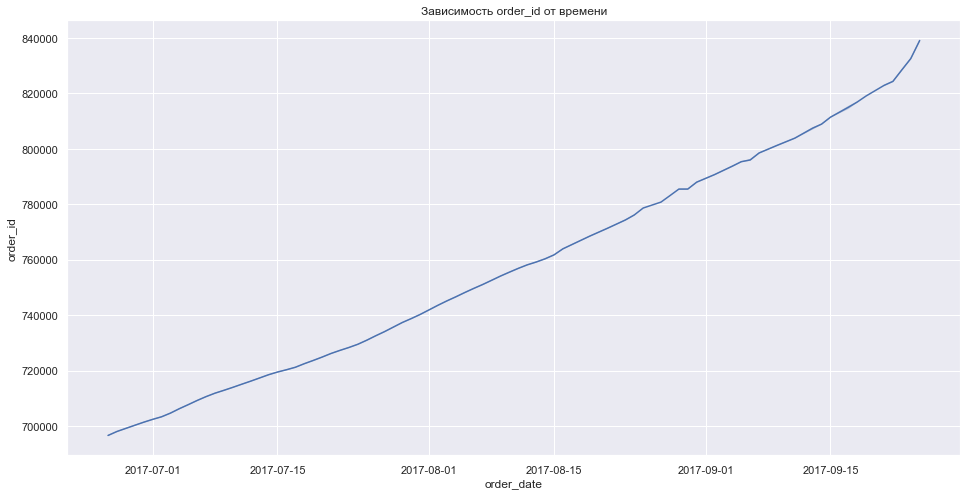

In [26]:
sns.lineplot(data=df, x='order_date', y='order_id')
plt.title('Зависимость order_id от времени')
plt.show()

- номер заявки линейно возрастает
- значит в период с середины августа до конца сентября уменьшелись заявки

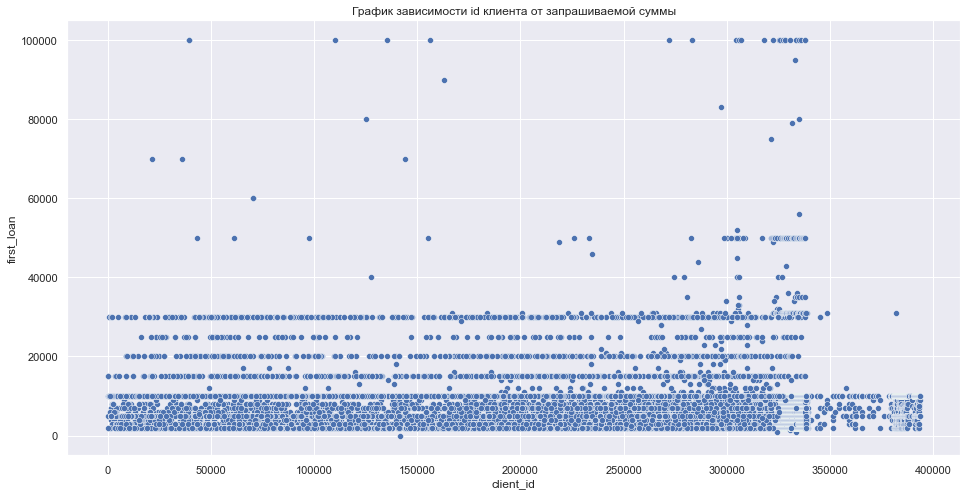

In [27]:
sns.scatterplot(df['client_id'], df['first_loan'])
plt.title('График зависимости id клиента от запрашиваемой суммы')
plt.show()

- в основном клиенты запрашивают суммы до 30 тысяч
- максимум 100 тысяч

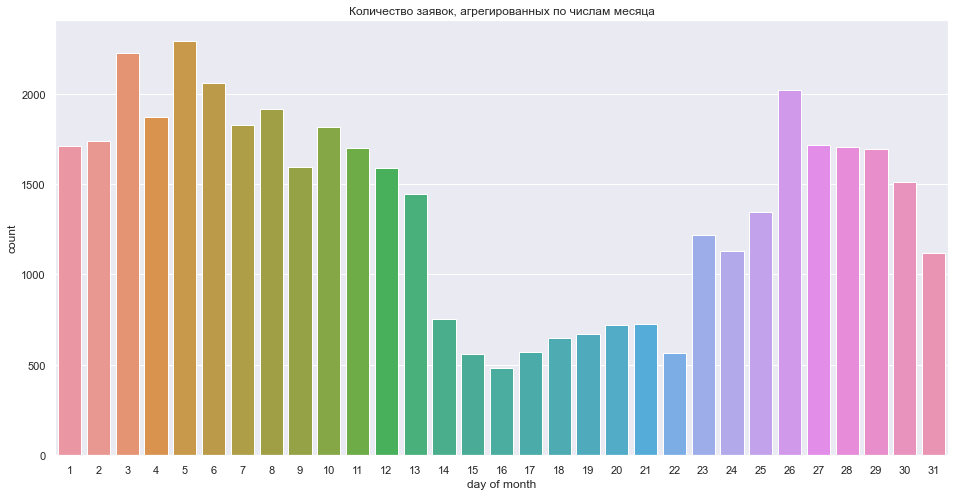

In [28]:
sns.countplot(df['order_date'].dt.day)
plt.title('Количество заявок, агрегированных по числам месяца')
plt.xlabel('day of month')
plt.show()

- большинство заявок приходится на 5 число месяца, предположительно клиенты берут займ до зарплаты 
- в середине месяца наименьшее количество заявок
- ближе к 26 числу заявок становится больше

Посмотрим запрашиваемый срок в заявках

<AxesSubplot:xlabel='first_days_quant', ylabel='count'>

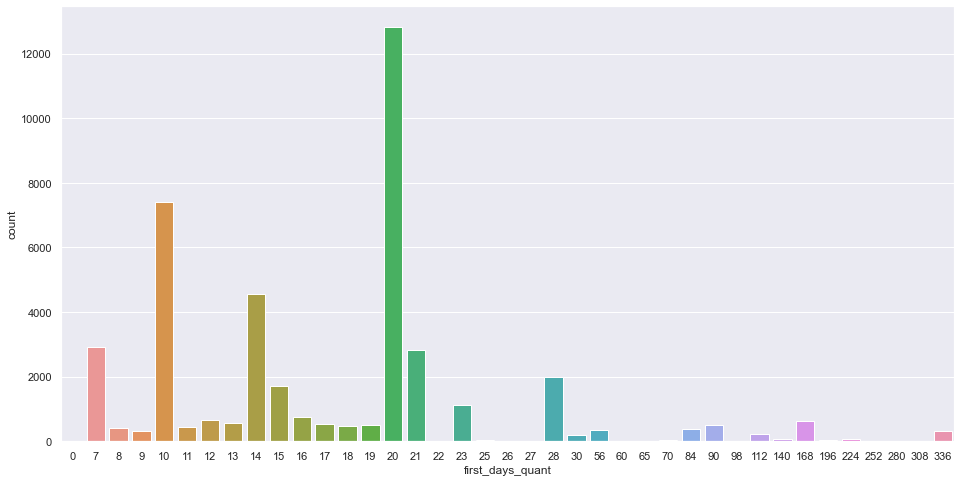

In [29]:
sns.countplot(data=df, x='first_days_quant')

- преимущественно срок 20 дней

Просмотрим корреляции между непрерывными переменными

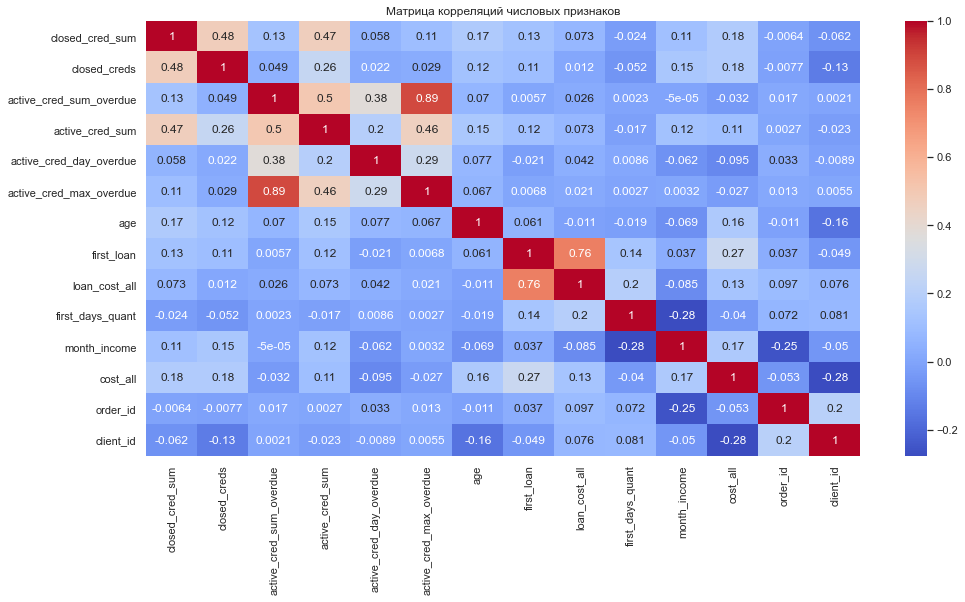

In [30]:
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций числовых признаков')
plt.show()

- сильная корреляция между суммарной задолженостью и максимальной задолженостью, что вполне логично
- выше среднего коррелируют сумма в заявке и одобренна суммой, тоже логично

Для исключения проблемы мультиколлинеарности, стоит исключить один из коррелирующих признаков. Либо использовать L2-ругуляризацию при моделировании. 

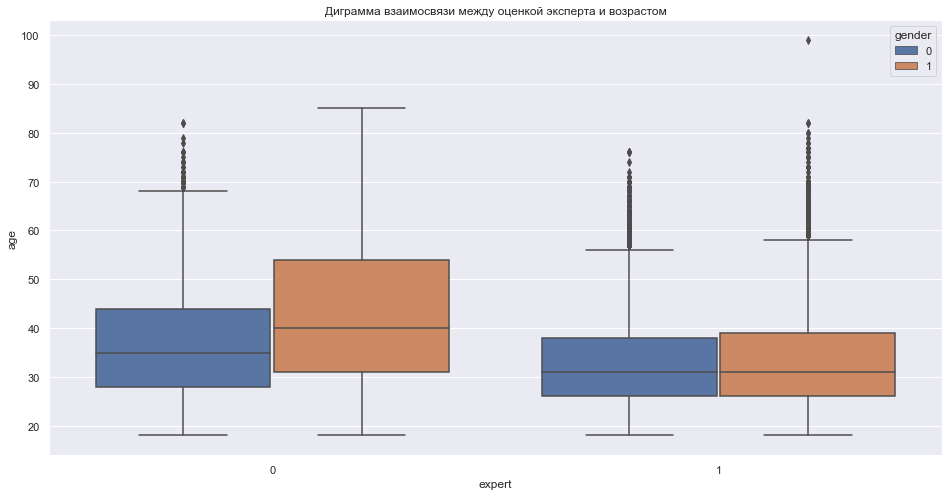

In [31]:
sns.boxplot(data=df, x='expert', y='age', hue='gender')
plt.title('Диграмма взаимосвязи между оценкой эксперта и возрастом')
plt.show()

- одобрительное решение чаще выносят более взрослым
- пол с меткой 1 чаще получает положительное решение

## Вывод

- посмотрели распределение данных, 28% клиентов с нулевым доходом
- обнаружили выборосы без явных аномалий, признаки оставили без фильтрации
- обнаружили, что на месяц снижалось количество заявок, и был увеличен процент отказов 
- посмотрели распределение заявок по дням месяца, в зарплатный период количество заявок снижается 

# 3. Моделирование

Разделим данные на тренировочную и тестовую. 
Мерику выберем *AUC-ROC*. Данная метрика позволяет оценить насколько точно модель разделяет "хороших" и "плохих" клиентов. ROC-кривая позволяет увидеть насколько построенная модель лучше модели, которая дает случайные ответы. 
Также выведем отчет о классификации посмотрим на метрики *F1-score* и *Recall*.

In [32]:
# добавляем курс
df = df.join(rc, on='order_date').fillna(method='ffill').fillna(method='bfill')

Извлечем дополонительные признаки из данных. Извлечем простые признаки, которые можно интерпретировать бизнесу. Добавим признаки из даты: месяц, день недели, день месяца. Посчитаем отношения между некоторыми переменными. 

In [33]:
def make_features(df):
    # функция для добавления признаков в датафрейм
    df['month'] = df['order_date'].dt.month
    df['weekday'] = df['order_date'].dt.weekday
    df['day_of_month'] = df['order_date'].dt.day
    df['income_loan_rate'] = df['month_income'] / df['first_loan']
    df['loan_days_rate'] = df['first_loan'] / df['first_days_quant']
    
    return df

# добавляем признаки
df = make_features(df)

Признаки `loan_cost_all`, `cost_all` могут содержать лик целевой переменной, поэтому их не будем использовать для построения модели

In [34]:
# определеяем матрицу признаков и вектор ответов
X = df.drop(['loan_cost_all', 'cost_all', 'order_id', 'order_date', 'expert'], axis=1)
y = df['expert']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер валидационной выборки:', X_val.shape, y_val.shape)
print('Размер тестовой выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (25765, 19) (25765,)
Размер валидационной выборки: (8589, 19) (8589,)
Размер тестовой выборки: (8589, 19) (8589,)


In [35]:
def estimate(model, X_val, y_val):
    # функция для оценки модели
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)    
    print(classification_report(y_val, y_pred))
    print('ROC-AUC: %.2f' %roc_auc_score(y_val, y_proba))

def roc_curve(model, X_val, y_val):
    # функция для построения ROC-кривой
    plot_roc_curve(model, X_val, y_val)
    plt.plot([0, 1], [0, 1], label='Random answer')
    plt.title('ROC-Curve')
    plt.legend()
    plt.show()

Для сравнения построим две модели:
- Логистическую регрессию
- Бустинг над деревьями решений

### Логистическая регрессия

In [36]:
from sklearn.linear_model import LogisticRegression

#обучаем и оценивам логистическую регрессию
logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train, y_train)

estimate(logreg, X_val, y_val)

              precision    recall  f1-score   support

           0       0.71      0.29      0.41      2293
           1       0.79      0.96      0.86      6296

    accuracy                           0.78      8589
   macro avg       0.75      0.62      0.64      8589
weighted avg       0.77      0.78      0.74      8589

ROC-AUC: 0.78


- логистическая регрессия больше ошибается на объектах с классом 0

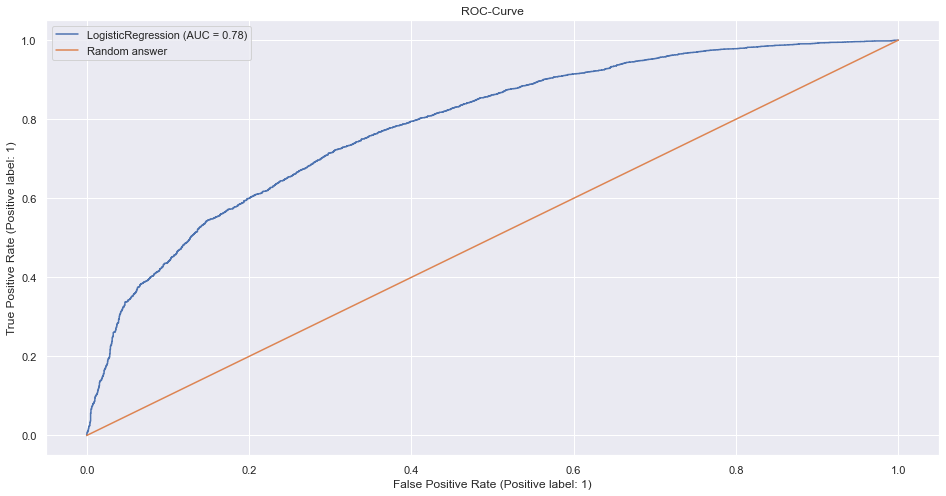

In [37]:
roc_curve(logreg, X_val, y_val)

Посмотрим важность признаков логистической регресси с помощью *Permutatation Importance*

In [38]:
# считаем значение PI
perm = PermutationImportance(logreg, random_state=42).fit(X_val, y_val)

# отображаем веса 
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.0591 ± 0.0038,client_id
0.0163 ± 0.0030,month_income
0.0138 ± 0.0026,active_cred_day_overdue
0.0024 ± 0.0013,active_cred_sum_overdue
0.0016 ± 0.0008,first_loan
0.0015 ± 0.0012,region
0.0006 ± 0.0006,age
0 ± 0.0000,month
0 ± 0.0000,gender
-0.0000 ± 0.0020,active_cred_max_overdue


- самый важный признак `client_id`, что вполне логично, признак можно использовать в качестве LTV клиента
- месяц и гендер не влияют на качество предсказания модели
- много признаков, которые ухудщают предсказания, может быть связано мультиколинеарностью

### LightGBM

In [39]:
#обучаем бустинг 
lgb_model = LGBMClassifier(random_state=42, n_estimators=1000)

lgb_model.fit(X_train, y_train, eval_metric='AUC', verbose=100, eval_set=[(X_val, y_val)], early_stopping_rounds=100)

estimate(lgb_model, X_val, y_val)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.941848	valid_0's binary_logloss: 0.265813
[200]	valid_0's auc: 0.942858	valid_0's binary_logloss: 0.263945
[300]	valid_0's auc: 0.943658	valid_0's binary_logloss: 0.263645
Early stopping, best iteration is:
[267]	valid_0's auc: 0.943648	valid_0's binary_logloss: 0.263153
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      2293
           1       0.91      0.95      0.93      6296

    accuracy                           0.89      8589
   macro avg       0.87      0.84      0.85      8589
weighted avg       0.89      0.89      0.89      8589

ROC-AUC: 0.94


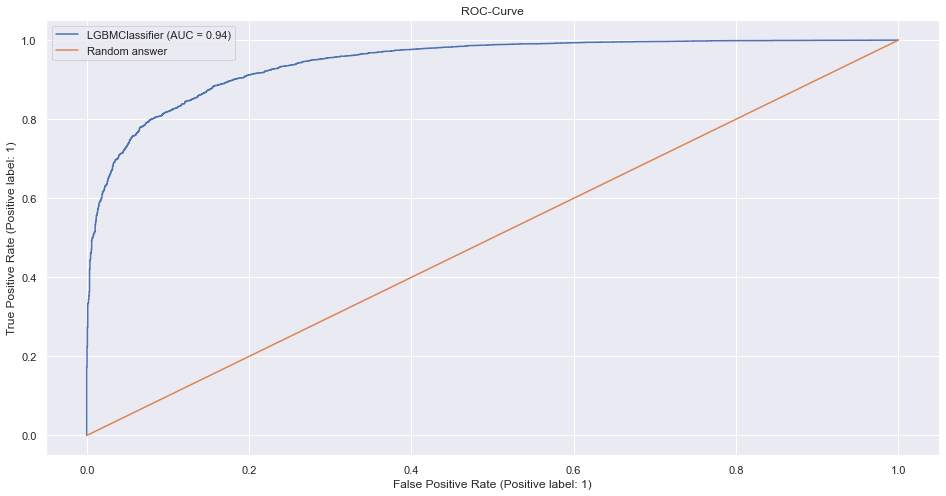

In [40]:
roc_curve(lgb_model, X_val, y_val)

Оценим признаки с помощью *Feature Importance*

In [41]:
# отображаем FI
explain_weights_lightgbm(lgb_model, feature_names=X_val.columns.tolist(), importance_type='gain')

Weight,Feature
0.2233,client_id
0.1289,first_days_quant
0.1068,month_income
0.0976,active_cred_day_overdue
0.0771,active_cred_sum_overdue
0.0540,age
0.0507,closed_creds
0.0443,first_loan
0.0426,active_cred_sum
0.0399,closed_cred_sum


Дополнительно посмотрим *Permutation Importance* для бустинга

In [42]:
# считаем значение PI
perm = PermutationImportance(lgb_model, random_state=42).fit(X_val, y_val)

# отображаем веса 
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.0539 ± 0.0033,first_days_quant
0.0530 ± 0.0035,client_id
0.0293 ± 0.0036,active_cred_sum_overdue
0.0263 ± 0.0007,month_income
0.0189 ± 0.0019,closed_creds
0.0169 ± 0.0027,active_cred_sum
0.0156 ± 0.0031,first_loan
0.0109 ± 0.0021,age
0.0091 ± 0.0029,region
0.0088 ± 0.0022,active_cred_max_overdue


- все признаки вносят вклад в качество модели

### Подбор гипперпараметров

Сделаем подбор гипперпараметров с помощью *RandomizedSearchCV*

In [43]:
#задаем признаки для кросс-валидации
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])

print('Размер выборки:', X_cv.shape, y_cv.shape)

Размер выборки: (34354, 19) (34354,)


In [55]:
lgb_model = LGBMClassifier(random_state=42)

# задаем сетку гипперпараметров
param_grid = {'learning_rate':[0.01, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3],
              'n_estimators': [100, 200, 300, 400, 500, 700, 1000],
              'max_depth': [i for i in range(1,11)],
              'min_data_in_leaf': [20, 50, 100, 200, 500],
              'num_leaves':[2, 4, 8, 16, 32, 64],
              'boosting_type' : ['gbdt', 'dart']}
          
#поиск лучших параметров         
rs_cv = RandomizedSearchCV(lgb_model, 
                    param_grid,
                    scoring='roc_auc',
                    n_jobs=-1,
                    cv=3,
                    n_iter=100,       
                    verbose=1)

rs_cv.fit(X_cv, y_cv)
print('Best ROC-AUC on CV:', rs_cv.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best ROC-AUC on CV: 0.946691458282237


- бустинг дает наилучший результат, продолжим работу данной моделью

# 4. Оценка модели

На данном этапе:
1. Оценим модель на тестовой выборке.
2. Проверим калибровку модели.
3. Посчитаем уровень одобрения и уровень просрочки.
4. Подберем порог для ответов модели.

In [56]:
# обучаем модель с лучшими параметрами
best_params = rs_cv.best_params_

lgb_model = LGBMClassifier(**best_params, random_state=42)

lgb_model.fit(X_train, y_train, eval_metric='AUC', verbose=100)

estimate(lgb_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.85      0.72      0.78      2273
           1       0.91      0.95      0.93      6316

    accuracy                           0.89      8589
   macro avg       0.88      0.84      0.85      8589
weighted avg       0.89      0.89      0.89      8589

ROC-AUC: 0.95


На тестовой выборке получили   
*ROC-AUC*: 0.95  
*F1-score*: 0.93  
*Recall*: 0.95  

Проверим насколько хорошо откалибрована модель, насколько вероятности в ответах модели близки к фактическим

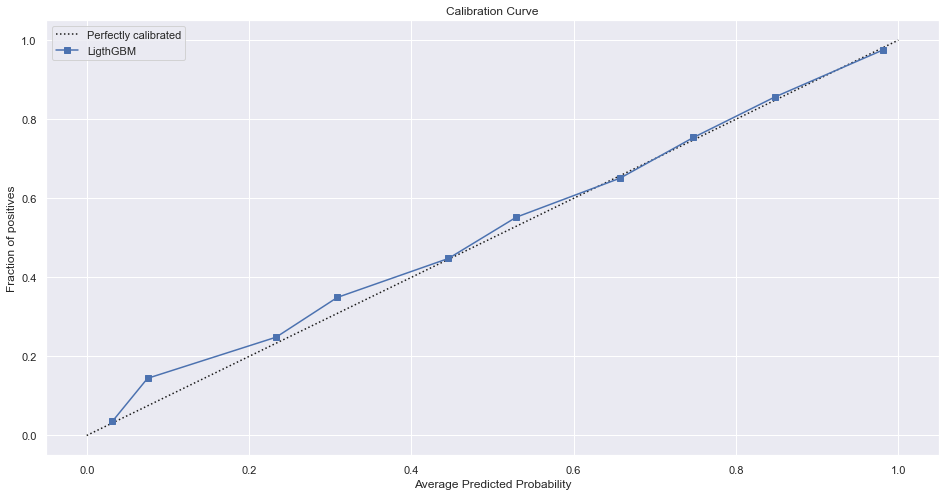

In [57]:
y_proba = lgb_model.predict_proba(X_test)[:, 1]

# используем функцию из sklearn
frac_of_pos, mean_pred_val = calibration_curve(y_test, y_proba, n_bins = 10)

# построим calibration curve
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(frac_of_pos, mean_pred_val, 's-', label='LigthGBM')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

- модель хорошо отколибрована

Посчитаем уровень одобрения и уровень просрочки

In [58]:
# сохраняем ответы 
lgb_preds = pd.DataFrame(lgb_model.predict_proba(X_test), columns=['prob_nondefault', 'prob_default'])
lgb_preds['true_loan_status'] = y_test.reset_index(drop=True)

In [59]:
# уровень одобрения
accept_rates = np.arange(1., 0, -0.05)

# cоздаем списки для переменных
thresholds = []
bad_rates = []
num_accept = []

# считаем порог, уровень просрочки, количество одобренных в зависимости от уровня одобрения
for rate in accept_rates:
    thresh = np.quantile(lgb_preds['prob_default'], rate).round(3)
    thresholds.append(np.quantile(lgb_preds['prob_default'], rate).round(3))
    lgb_preds['pred_loan_status'] = lgb_preds['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    accepted_loans = lgb_preds[lgb_preds['pred_loan_status'] == 0]
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))
    num_accept.append(len(lgb_preds[lgb_preds['prob_default'] < np.quantile(lgb_preds['prob_default'], rate)]))

In [60]:
# занесем переменные в датафрейм
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accept),
                        columns = ['Уровень одобрения','Порог','Уровень просрочки', 'Количество одобренных'])

# считаем средний займ и оценку
strat_df['Средний займ'] = X_test['first_loan'].mean()
strat_df['Оценочная стоимость'] = ((strat_df['Количество одобренных'] * 
                                    (1 - strat_df['Уровень просрочки'])) * strat_df['Средний займ'])\
                                - (strat_df['Количество одобренных'] * 
                                   strat_df['Уровень просрочки'] * strat_df['Средний займ'])


pd.options.display.float_format = '{:,.2f}'.format
strat_df

,Уровень одобрения,Порог,Уровень просрочки,Количество одобренных,Средний займ,Оценочная стоимость
0,1.00,1.00,0.73,8588,"7,741.96","-31,249,340.28"
1,0.95,1.00,0.72,8159,"7,741.96","-27,666,995.73"
2,0.90,1.00,0.70,7730,"7,741.96","-24,536,595.88"
3,0.85,1.00,0.69,7300,"7,741.96","-21,363,166.21"
4,0.80,0.99,0.67,6871,"7,741.96","-18,192,693.97"
5,0.75,0.99,0.65,6441,"7,741.96","-14,660,594.75"
6,0.70,0.98,0.62,6012,"7,741.96","-11,449,988.18"
7,0.65,0.97,0.59,5583,"7,741.96","-8,212,439.60"
8,0.60,0.96,0.56,5153,"7,741.96","-4,867,107.43"
9,0.55,0.95,0.53,4724,"7,741.96","-1,828,651.10"


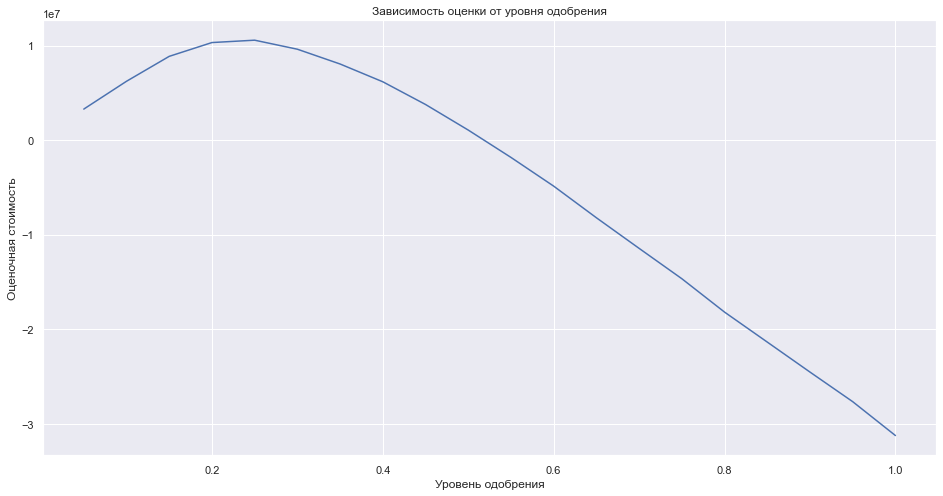

In [61]:
# строим график
sns.lineplot(data=strat_df, x='Уровень одобрения', y='Оценочная стоимость')
plt.title('Зависимость оценки от уровня одобрения')
plt.show()

In [62]:
# строка с максимальной оценкой
strat_df.loc[strat_df['Оценочная стоимость'] == np.max(strat_df['Оценочная стоимость'])]\
.style.set_caption('Оптимальный порог')

,Уровень одобрения,Порог,Уровень просрочки,Количество одобренных,Средний займ,Оценочная стоимость
15,0.250000,0.568000,0.182000,2147,7741.960647,10571585.328257


Нашли оптимальный порог - `0.57`

# 5. Интерпретация модели

Для интерпретации модели будем использовать расчет значения Шепли. Как работает значение Шепли коротко: считаем разницу между предсказанием модели без интересующего нас признака и предсказанием с ним. Получается некоторая мера важности признаков.

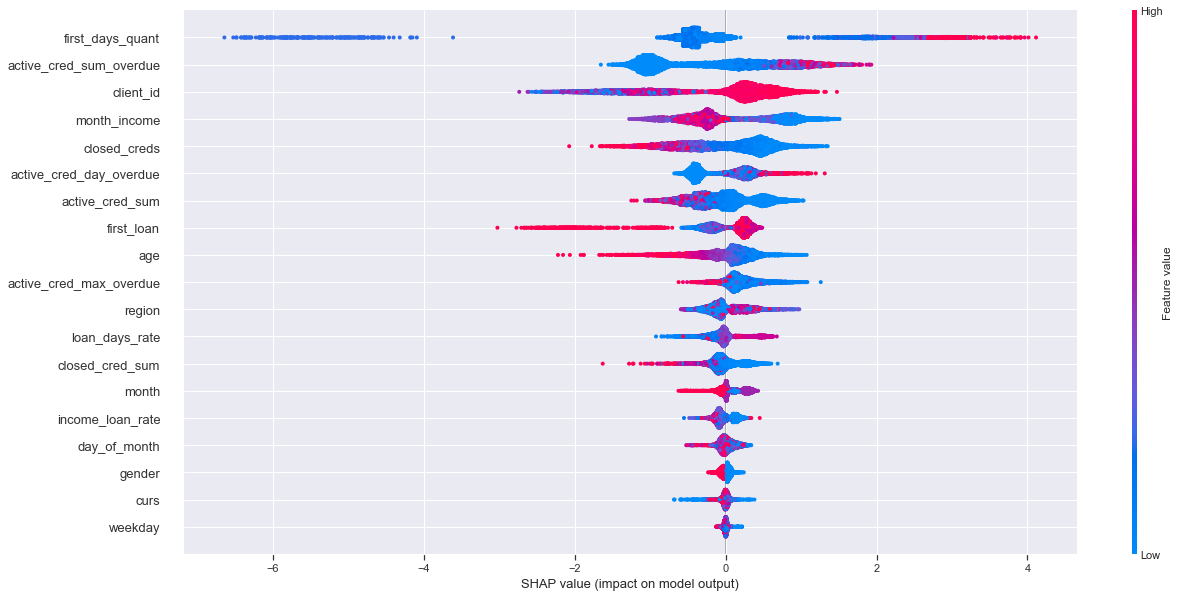

In [63]:
shap.initjs()

#создаем объект для расчета значений Шепли
explainer = shap.TreeExplainer(lgb_model)

#cчитаем значния Шепли
shap_values = explainer.shap_values(X_test)

#построим сводный график
shap.summary_plot(shap_values[1], X_test, plot_size=(20,10), title='Summary plot SHAP values')

- запрошенная сумма кредита - самый важный признак, чем она меньше, тем меньше вероятность отказа
- увеличение суммы задолженности увеличивает вероятность отказа
- новые клиенты с большей вероятнотью получают отказ

# 6. Вывод

1. Загрузили данные, сделали предобработку. 
2. Провели исследовательский анализ данных. Нашли несколько инсайтов в данных:
    - 28 % клиентов с нулевым доходом;
    - в зарплатный период количество заявок снижается.
3. Построили две модели: логистическую регрессию и бустинг над деревьями решений. Лучшей моделью выбрали бустинг.
4. Провели тестирование и оценку модели. Итоговая метрика *ROC-AUC*: 0.95. Подобрали оптимальных порог исходя из наилучшей оценки кредита.
5. Сделали интерпретацию модели с помощью *Shap-value*. Топ-3 признака: запрошенная сумма кредита,  суммарная задолженность по активным кредитам, id клиента. Предсказания модели вполне логичны.
6. Идеи по улучшению модели:
    - построить отдельные модели для клиентов с нулевым доходом и ненулевым доходом;
    - извлечь дополнительные признаки: отношения между переменными, выделить сегменты клиентов;
    - протестировать нейросетевые SOTA-решения для кредитного скоринга.